### **Background**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install pgmpy

     |████████████████████████████████| 337kB 5.5MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
import math

from copy import copy
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import HillClimbSearch, BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from typing import List
from itertools import chain

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [4]:
data = pd.read_csv('/content/drive/My Drive/data/acs2015_census_tract_data.csv')
data = data[data.notnull().T.all()]
# data = data.sample(frac=0.05)
data.head()

,CensusTract,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga,1948,940,1008,0.9,87.4,7.7,0.3,0.6,0.0,1503,61838.0,11900.0,25713.0,4548.0,8.1,8.4,34.7,17.0,21.3,11.9,15.2,90.2,4.8,0.0,0.5,2.3,2.1,25.0,943,77.1,18.3,4.6,0.0,5.4
1,1001020200,Alabama,Autauga,2156,1059,1097,0.8,40.4,53.3,0.0,2.3,0.0,1662,32303.0,13538.0,18021.0,2474.0,25.5,40.3,22.3,24.7,21.5,9.4,22.0,86.3,13.1,0.0,0.0,0.7,0.0,23.4,753,77.0,16.9,6.1,0.0,13.3
2,1001020300,Alabama,Autauga,2968,1364,1604,0.0,74.5,18.6,0.5,1.4,0.3,2335,44922.0,5629.0,20689.0,2817.0,12.7,19.7,31.4,24.9,22.1,9.2,12.4,94.8,2.8,0.0,0.0,0.0,2.5,19.6,1373,64.1,23.6,12.3,0.0,6.2
3,1001020400,Alabama,Autauga,4423,2172,2251,10.5,82.8,3.7,1.6,0.0,0.0,3306,54329.0,7003.0,24125.0,2870.0,2.1,1.6,27.0,20.8,27.0,8.7,16.4,86.6,9.1,0.0,0.0,2.6,1.6,25.3,1782,75.7,21.2,3.1,0.0,10.8
4,1001020500,Alabama,Autauga,10763,4922,5841,0.7,68.5,24.8,0.0,3.8,0.0,7666,51965.0,6935.0,27526.0,2813.0,11.4,17.5,49.6,14.2,18.2,2.1,15.8,88.0,10.5,0.0,0.0,0.6,0.9,24.8,5037,67.1,27.6,5.3,0.0,4.2


### **Step 1.** Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest – predictors).

In [5]:
TARGETS = ['Poverty', 'Professional', 'Unemployment']
PREDICTORS = ['TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native']

data = data[TARGETS + PREDICTORS]
data.head()

,Poverty,Professional,Unemployment,TotalPop,Men,Women,Hispanic,White,Black,Native
0,8.1,34.7,5.4,1948,940,1008,0.9,87.4,7.7,0.3
1,25.5,22.3,13.3,2156,1059,1097,0.8,40.4,53.3,0.0
2,12.7,31.4,6.2,2968,1364,1604,0.0,74.5,18.6,0.5
3,2.1,27.0,10.8,4423,2172,2251,10.5,82.8,3.7,1.6
4,11.4,49.6,4.2,10763,4922,5841,0.7,68.5,24.8,0.0


### **Step 2.** Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

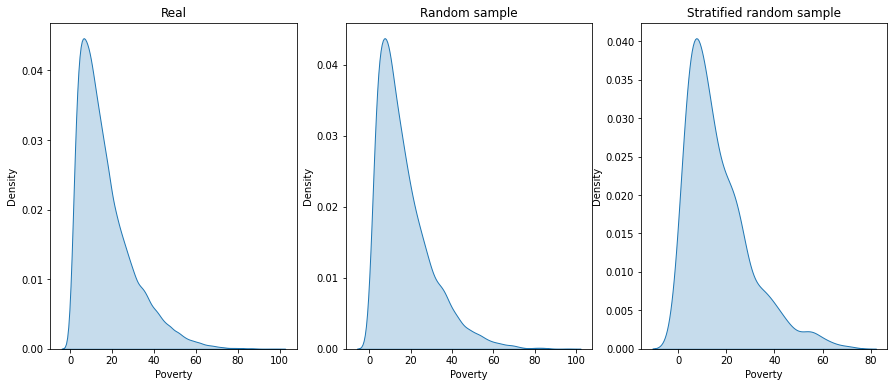

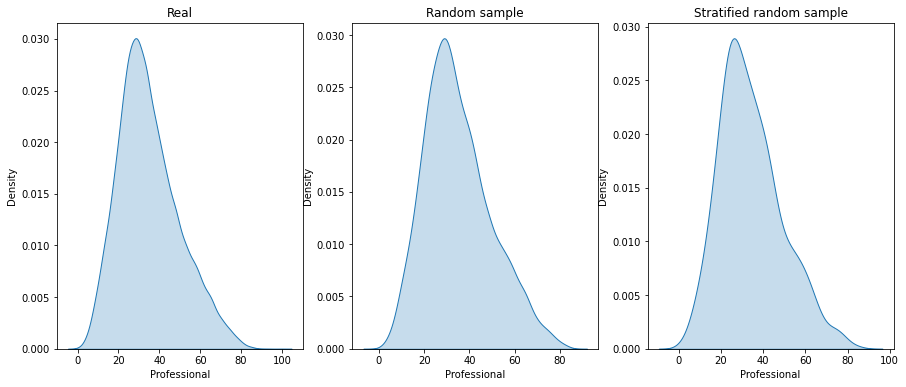

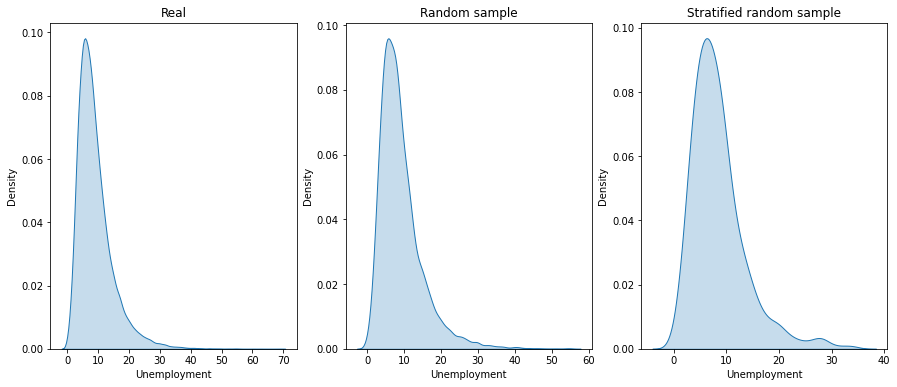

In [6]:
def draw_sampling_plots(target):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    sns.kdeplot(ax=axes[0], data=data, x=target, shade=True)

    sample_data = data.sample(frac=.15)
    sns.kdeplot(ax=axes[1], data=sample_data, x=target, shade=True)

    sample_data_0 = data[data['Men'] < data['Women']].sample(n=300, axis=0)
    sample_data_1 = data[data['Men'] >= data['Women']].sample(n=300, axis=0)
    sample_data = pd.concat([sample_data_0, sample_data_1])
    sns.kdeplot(ax=axes[2], data=sample_data, x=target, shade=True)

    axes[0].set_title('Real')
    axes[1].set_title('Random sample')
    axes[2].set_title('Stratified random sample')
    plt.show()

for target in TARGETS:
    draw_sampling_plots(target)

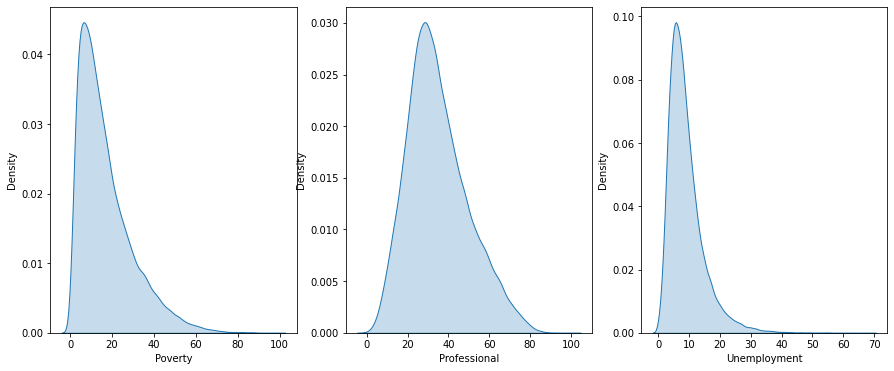

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for i, target in enumerate(TARGETS):
    sns.kdeplot(ax=axes[i], data=data, x=target, shade=True)
plt.show()

In [37]:
import scipy.stats as st
from numpy.random import random
from scipy import interpolate

def best_fit_distribution(data, bins=200, ax=None):
    y, x = np.histogram(data, bins=bins, density=True, normed = True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    DISTRIBUTIONS = [        
        st.dgamma,st.expon, st.exponnorm, st.gamma, st.laplace,st.levy, 
        st.logistic, st.lognorm, st.norm,st.pareto,st.pearson3,st.powerlaw,
        st.weibull_min
    ]

    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    for distribution in DISTRIBUTIONS:
        params = distribution.fit(data)

        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y - pdf, 2.0))

        if best_sse > sse > 0:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution.name, best_params


def its_function(dist, params, size):
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    x = np.linspace(start, end, size)
    y = dist.pdf(x, *params)

    cdf_y = dist.cdf(x, *params)
    cdf_y = cdf_y/cdf_y.max()

    return interpolate.interp1d(cdf_y,x, fill_value="extrapolate")

def its(dist, params, N=10000):
    uniform_samples = random(int(N))
    inverse_cdf = its_function(dist, params, N)
    samples = inverse_cdf(uniform_samples)
    return samples


dists = []
for target_name in TARGETS:
    df_ = data[target_name]
    target_values = df_[df_ < np.percentile(df_, 95)]
    dist_name, params = best_fit_distribution(target_values)
    dists.append({'target_name': target_name, 'params': params, 
                  'dist': getattr(st, dist_name), 'dist_name': dist_name})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

The normed argument is ignored when density is provided. In future passing both will result in an error.

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

The normed argument is ignored when density is provided. In future passing both will result in an error.

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

The normed argument is ignored when density is provided. In future passing both will result in an error.

/usr/

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



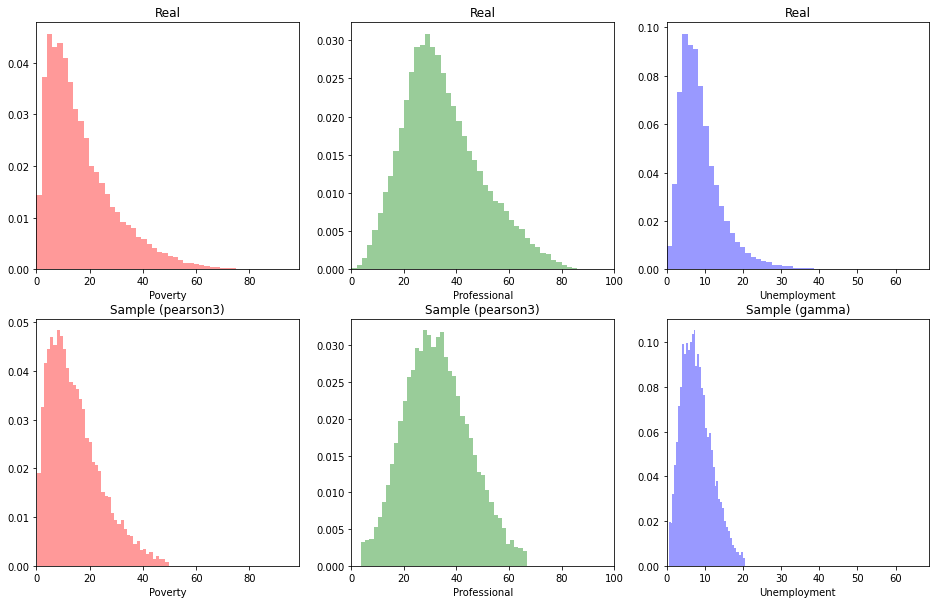

In [45]:
inverse_transform_samples = {}

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
colors=['r', 'g', 'b']

for i, dist in enumerate(dists):
    target_name = dist['target_name']

    samples = its(dist['dist'], dist['params'])
    inverse_transform_samples[dist['target_name']] = samples

    axes[0, i].set_xlim(data[target_name].min(), data[target_name].max())
    axes[1, i].set_xlim(data[target_name].min(), data[target_name].max())

    sns.distplot(data[target_name], ax=axes[0, i], color=colors[i],
                 norm_hist=True, hist=True, kde=False, axlabel=target_name)
    axes[0, i].set_title('Real')
    
    sns.distplot(inverse_transform_samples[target_name], ax=axes[1, i], color=colors[i],
                 norm_hist=True, hist=True, kde=False, axlabel=target_name)
    axes[1, i].set_title(f"Sample ({dist['dist_name']})")

### **Step 3.** Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

In [8]:
correlation = data.corr().iloc[:3, 3:]
correlation

,TotalPop,Men,Women,Hispanic,White,Black,Native
Poverty,-0.151546,-0.153656,-0.144568,0.350066,-0.529740,0.411073,0.086930
Professional,0.076854,0.067048,0.083962,-0.335693,0.351485,-0.247396,-0.043388
Unemployment,-0.126437,-0.134667,-0.114281,0.225366,-0.495322,0.484606,0.092296


In [9]:
abs(correlation) > 0.3

,TotalPop,Men,Women,Hispanic,White,Black,Native
Poverty,False,False,False,True,True,True,False
Professional,False,False,False,True,True,False,False
Unemployment,False,False,False,False,True,True,False


### **Step 4.** Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [10]:
def addEdge(start, end, edge_x, edge_y, lengthFrac=1, arrowPos = None, arrowLength=0.025, arrowAngle = 30, dotSize=20):
    # Get start and end cartesian coordinates
    x0, y0 = start
    x1, y1 = end

    # Incorporate the fraction of this segment covered by a dot into total reduction
    length = math.sqrt( (x1-x0)**2 + (y1-y0)**2 )
    dotSizeConversion = .0565/20 # length units per dot size
    convertedDotDiameter = dotSize * dotSizeConversion
    lengthFracReduction = convertedDotDiameter / length
    lengthFrac = lengthFrac - lengthFracReduction

    # If the line segment should not cover the entire distance, get actual start and end coords
    skipX = (x1-x0)*(1-lengthFrac)
    skipY = (y1-y0)*(1-lengthFrac)
    x0 = x0 + skipX/2
    x1 = x1 - skipX/2
    y0 = y0 + skipY/2
    y1 = y1 - skipY/2

    # Append line corresponding to the edge
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None) # Prevents a line being drawn from end of this edge to start of next edge
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

    # Draw arrow
    if not arrowPos == None:

        # Find the point of the arrow; assume is at end unless told middle
        pointx = x1
        pointy = y1

        eta = math.degrees(math.atan((x1-x0)/(y1-y0))) if y1!=y0 else 90.0

        if arrowPos == 'middle' or arrowPos == 'mid':
            pointx = x0 + (x1-x0)/2
            pointy = y0 + (y1-y0)/2

        # Find the directions the arrows are pointing
        signx = (x1-x0)/abs(x1-x0) if x1!=x0 else +1    #verify this once
        signy = (y1-y0)/abs(y1-y0) if y1!=y0 else +1    #verified

        # Append first arrowhead
        dx = arrowLength * math.sin(math.radians(eta + arrowAngle))
        dy = arrowLength * math.cos(math.radians(eta + arrowAngle))
        edge_x.append(pointx)
        edge_x.append(pointx - signx**2 * signy * dx)
        edge_x.append(None)
        edge_y.append(pointy)
        edge_y.append(pointy - signx**2 * signy * dy)
        edge_y.append(None)

        # And second arrowhead
        dx = arrowLength * math.sin(math.radians(eta - arrowAngle))
        dy = arrowLength * math.cos(math.radians(eta - arrowAngle))
        edge_x.append(pointx)
        edge_x.append(pointx - signx**2 * signy * dx)
        edge_x.append(None)
        edge_y.append(pointy)
        edge_y.append(pointy - signx**2 * signy * dy)
        edge_y.append(None)

    return edge_x, edge_y


def add_arrows(source_x: List[float], target_x: List[float], source_y: List[float], target_y: List[float],
               arrowLength=0.025, arrowAngle=30):
    pointx = list(map(lambda x: x[0] + (x[1] - x[0]) / 2, zip(source_x, target_x)))
    pointy = list(map(lambda x: x[0] + (x[1] - x[0]) / 2, zip(source_y, target_y)))
    etas = list(map(lambda x: math.degrees(math.atan((x[1] - x[0]) / (x[3] - x[2]))),
                    zip(source_x, target_x, source_y, target_y)))

    signx = list(map(lambda x: (x[1] - x[0]) / abs(x[1] - x[0]), zip(source_x, target_x)))
    signy = list(map(lambda x: (x[1] - x[0]) / abs(x[1] - x[0]), zip(source_y, target_y)))

    dx = list(map(lambda x: arrowLength * math.sin(math.radians(x + arrowAngle)), etas))
    dy = list(map(lambda x: arrowLength * math.cos(math.radians(x + arrowAngle)), etas))
    none_spacer = [None for _ in range(len(pointx))]
    arrow_line_x = list(map(lambda x: x[0] - x[1] ** 2 * x[2] * x[3], zip(pointx, signx, signy, dx)))
    arrow_line_y = list(map(lambda x: x[0] - x[1] ** 2 * x[2] * x[3], zip(pointy, signx, signy, dy)))

    arrow_line_1x_coords = list(chain(*zip(pointx, arrow_line_x, none_spacer)))
    arrow_line_1y_coords = list(chain(*zip(pointy, arrow_line_y, none_spacer)))

    dx = list(map(lambda x: arrowLength * math.sin(math.radians(x - arrowAngle)), etas))
    dy = list(map(lambda x: arrowLength * math.cos(math.radians(x - arrowAngle)), etas))
    none_spacer = [None for _ in range(len(pointx))]
    arrow_line_x = list(map(lambda x: x[0] - x[1] ** 2 * x[2] * x[3], zip(pointx, signx, signy, dx)))
    arrow_line_y = list(map(lambda x: x[0] - x[1] ** 2 * x[2] * x[3], zip(pointy, signx, signy, dy)))

    arrow_line_2x_coords = list(chain(*zip(pointx, arrow_line_x, none_spacer)))
    arrow_line_2y_coords = list(chain(*zip(pointy, arrow_line_y, none_spacer)))

    x_arrows = arrow_line_1x_coords + arrow_line_2x_coords
    y_arrows = arrow_line_1y_coords + arrow_line_2y_coords

    return x_arrows, y_arrows


def graph_node(graph):
    node_x = []
    node_y = []
    node_name = []

    for node in graph.nodes():
      x, y = graph.nodes[node]['pos']
      node_x.append(x)
      node_y.append(y)
      node_name.append(node)

    return node_x, node_y, node_name


def graph_edge(graph, node_size=20):
    edge_x = []
    edge_y = []

    for edge in graph.edges():
        start = graph.nodes[edge[0]]['pos']
        end = graph.nodes[edge[1]]['pos']
        edge_x, edge_y = addEdge(start, end, edge_x, edge_y, .8, 'end', .04, 30, node_size)

    return edge_x, edge_y


def plot_graph(model, node_color='#87CEFA', node_size=20, line_width=2, line_color='#000000'):
  # Making graph
  graph = nx.DiGraph()
  graph.add_edges_from(model.edges())
  pos = nx.layout.circular_layout(graph)

  for node in graph.nodes:
    graph.nodes[node]['pos'] = list(pos[node])

  # Making list of nodes for plotly
  node_x, node_y, node_name = graph_node(graph)

  # Making a list of edges for plotly, including line segments that result in arrowheads
  edge_x, edge_y = graph_edge(graph, node_size)

  edge_trace = go.Scatter(x=edge_x,
                          y=edge_y,
                          line=dict(width=line_width, color=line_color),
                          hoverinfo='none',
                          mode='lines')

  node_trace = go.Scatter(x=node_x,
                          y=node_y,
                          mode='markers+text',
                          hoverinfo='text',
                          text=node_name,
                          textposition="top center",
                          marker=dict(showscale=False,
                                      color=node_color,
                                      size=node_size)
                          )

  fig = go.Figure(data=[edge_trace, node_trace],
                  layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                  )
                
  # Note: if you don't use fixed ratio axes, the arrows won't be symmetrical
  fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1), plot_bgcolor='rgb(255,255,255)')

  fig.show()


def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in tqdm(enumerate(data.columns)):
        accuracy = 0
        test_param = data[param]
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

In [11]:
transformed_data = copy(data)
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(data)
transformed_data = pd.DataFrame(data_discrete, columns=data.columns)
transformed_data.head()

,Poverty,Professional,Unemployment,TotalPop,Men,Women,Hispanic,White,Black,Native
0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
1,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0
3,0.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0
4,1.0,3.0,0.0,3.0,3.0,3.0,0.0,3.0,2.0,0.0


In [12]:
hc = HillClimbSearch(transformed_data, scoring_method=K2Score(transformed_data))
K2Score_model = hc.estimate()
plot_graph(K2Score_model)

  0%|          | 25/1000000 [00:06<71:26:45,  3.89it/s]


In [13]:
blacklist = [(x, y) for x in transformed_data.columns.to_list() for y in PREDICTORS if x != y]
K2Score_model_bl = hc.estimate(black_list=blacklist)
plot_graph(K2Score_model_bl)

  0%|          | 14/1000000 [00:03<72:56:36,  3.81it/s]


In [14]:
accuracy_k2 = accuracy_params_restoration(BayesianModel(K2Score_model.edges()), transformed_data.sample(n=3000))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
1it [00:01,  1.01s/it]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
2it [00:01,  1.00it/s]
0it [00:00, ?it/s]
Finding Eliminatio

In [15]:
accuracy_k2

,Parameter,accuracy
0,Poverty,1
1,Professional,1
2,Unemployment,1
3,TotalPop,1
4,Men,1
5,Women,1
6,Hispanic,1
7,White,1
8,Black,1
9,Native,1


### **Step 5.** Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

In [16]:
hc_BicScore = HillClimbSearch(transformed_data, scoring_method=BicScore(transformed_data))
BicScore_model = hc_BicScore.estimate()
plot_graph(BicScore_model)

  0%|          | 25/1000000 [00:06<68:51:14,  4.03it/s]


In [17]:
BicScore_model_bl = hc_BicScore.estimate(black_list=blacklist)
plot_graph(BicScore_model_bl)

  0%|          | 14/1000000 [00:03<72:07:49,  3.85it/s]


In [18]:
accuracy_k2 = accuracy_params_restoration(BayesianModel(BicScore_model.edges()), transformed_data.sample(n=3000))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
1it [00:00,  1.57it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
2it [00:01,  1.50it/s]
0it [00:00, ?it/s]
Finding Eliminatio

In [19]:
accuracy_k2

,Parameter,accuracy
0,Poverty,1
1,Professional,1
2,Unemployment,1
3,TotalPop,1
4,Men,1
5,Women,1
6,Hispanic,1
7,White,0.8
8,Black,1
9,Native,1


In [20]:
hc_BDeuScore = HillClimbSearch(transformed_data, scoring_method=BDeuScore(transformed_data))
BDeuScore_model = hc_BDeuScore.estimate()
plot_graph(BDeuScore_model)

  0%|          | 25/1000000 [00:06<69:36:22,  3.99it/s]


In [21]:
BDeuScore_model_bl = hc_BDeuScore.estimate(black_list=blacklist)
plot_graph(BDeuScore_model_bl)

  0%|          | 14/1000000 [00:03<72:52:12,  3.81it/s]


In [22]:
accuracy_k2 = accuracy_params_restoration(BayesianModel(BDeuScore_model.edges()), transformed_data.sample(n=3000))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
1it [00:01,  1.90s/it]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
2it [00:03,  1.82s/it]
0it [00:00, ?it/s]
Finding Eliminatio

In [23]:
accuracy_k2

,Parameter,accuracy
0,Poverty,1
1,Professional,1
2,Unemployment,1
3,TotalPop,1
4,Men,1
5,Women,1
6,Hispanic,1
7,White,1
8,Black,1
9,Native,1


### **Step 6.** Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

In [24]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

In [25]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame, axes=None):
    final_df = pd.DataFrame()
    
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    
    sns.barplot(ax=axes, x=parametr, y="Probability", hue="Data", data=final_df)

In [26]:
sample_K2 = sampling(K2Score_model_bl, transformed_data, transformed_data.shape[0])
sample_Bic = sampling(BicScore_model_bl, transformed_data, transformed_data.shape[0])
sample_BDeu = sampling(BDeuScore_model_bl, transformed_data, transformed_data.shape[0])

Generating for node: Professional: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


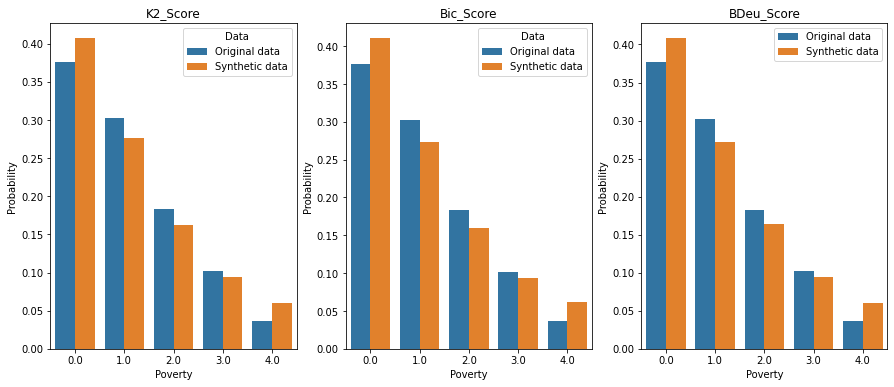

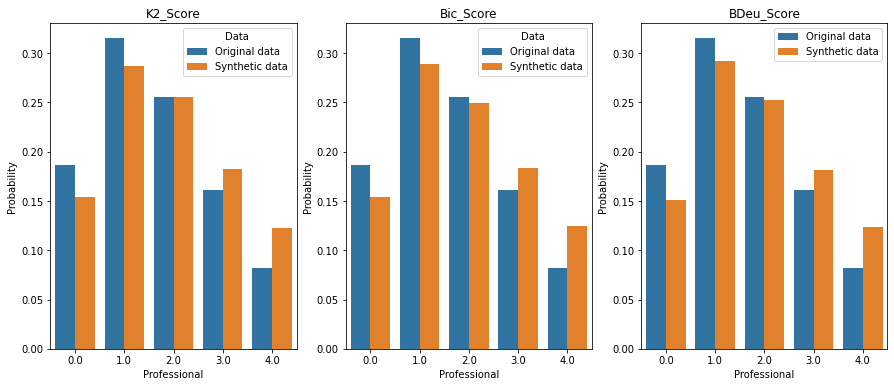

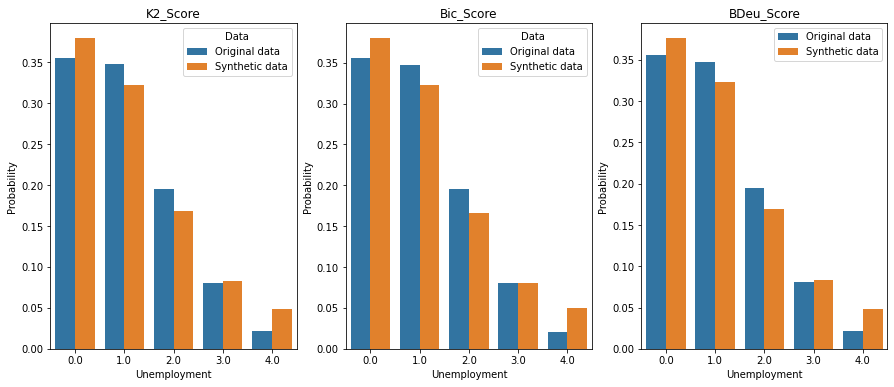

In [27]:
def draw_probability_plot(target):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    draw_comparative_hist(target, transformed_data, sample_K2, axes=axes[0])
    draw_comparative_hist(target, transformed_data, sample_Bic, axes=axes[1])
    draw_comparative_hist(target, transformed_data, sample_BDeu, axes=axes[2])

    axes[0].set_title('K2_Score')
    axes[1].set_title('Bic_Score')
    axes[2].set_title('BDeu_Score')
    plt.legend()
    plt.show()

for target in TARGETS:
    draw_probability_plot(target)

In [28]:
for in_blacklist in list(set(transformed_data.columns) - set(sample_K2.columns)):
  sample_K2[in_blacklist] = transformed_data[in_blacklist].copy()
  sample_Bic[in_blacklist] = transformed_data[in_blacklist].copy()
  sample_BDeu[in_blacklist] = transformed_data[in_blacklist].copy()

sample_K2[sample_K2.columns] = est.inverse_transform(sample_K2[sample_K2.columns].values)
sample_Bic[sample_K2.columns] = est.inverse_transform(sample_Bic[sample_K2.columns].values)
sample_BDeu[sample_K2.columns] = est.inverse_transform(sample_BDeu[sample_K2.columns].values)

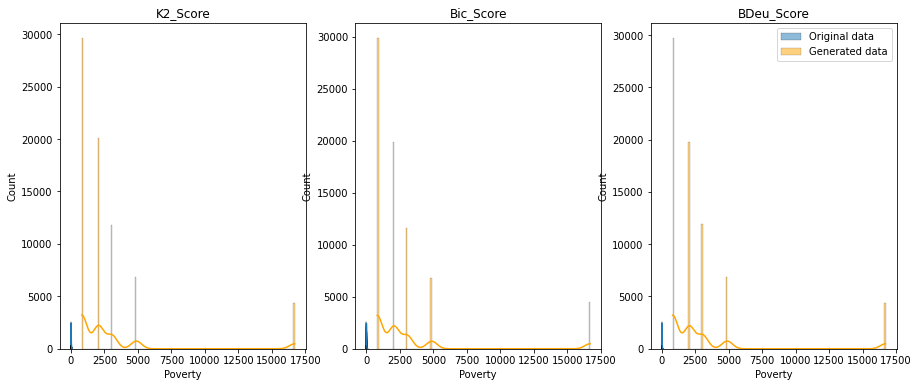

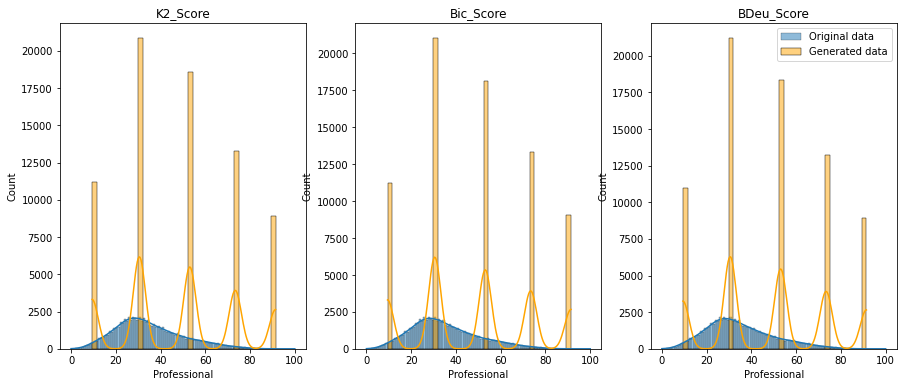

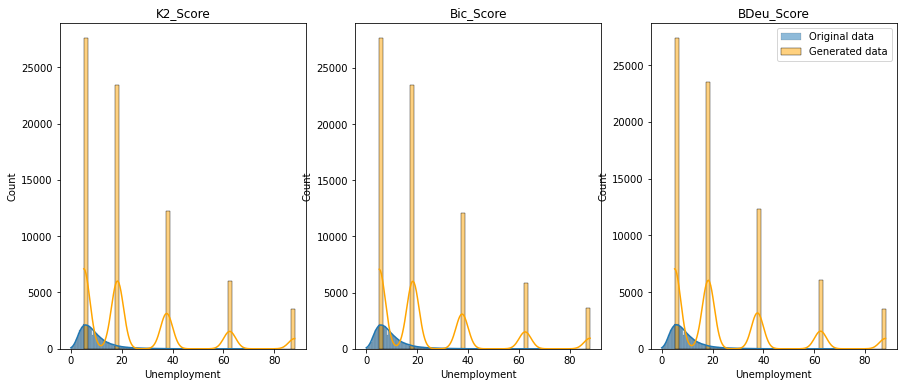

In [29]:
def draw_count_plot(target):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    sns.histplot(data[target], label='Original data', kde=True, ax=axes[0])
    sns.histplot(sample_K2[target], label='Generated data', kde=True, color='orange', ax=axes[0])

    sns.histplot(data[target], label='Original data', kde=True, ax=axes[1])
    sns.histplot(sample_Bic[target], label='Generated data', kde=True, color='orange', ax=axes[1])

    sns.histplot(data[target], label='Original data', kde=True, ax=axes[2])
    sns.histplot(sample_BDeu[target], label='Generated data', kde=True, color='orange', ax=axes[2])

    axes[0].set_title('K2_Score')
    axes[1].set_title('Bic_Score')
    axes[2].set_title('BDeu_Score')
    plt.legend()
    plt.show()

for target in TARGETS:
    draw_count_plot(target)